<a href="https://colab.research.google.com/github/roman-ruzica/hackprague2020_ganchors/blob/main/hackaton2020_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import sklearn as sklearn
import statsmodels.api as sm
import calendar
from joblib import dump, load
import datetime
import matplotlib.pyplot as plt
import statistics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

import tensorflow as tf

from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Make numpy printouts easier to read.
np.set_printoptions(precision=2, suppress=True)



2.3.0


In [3]:
data3 = pd.read_csv("/content/drive/My Drive/CS_HACKATHON/enriched_data.csv")

In [4]:
client_table = data3.groupby(["client_id", "population", "client_home_region", "client_gender", "merchant_category", "client_year_of_birth"]).agg({"amount":"sum"}).reset_index()

client_table2 = client_table.groupby(["client_id", "client_gender", "population", "client_home_region", "client_year_of_birth"]).agg({"amount":"sum"})\
.rename({"amount":"tot_m_amount"}).reset_index()
client_table_tot = client_table.merge(client_table2,on = ["client_id", "population", "client_home_region", "client_gender", "client_year_of_birth"])
client_table_tot["client_home_region"] = client_table_tot["client_home_region"].astype('category')
client_table_tot["client_home_region_cat"] = client_table_tot["client_home_region"].cat.codes
client_table_tot[["gen_dummy", "gd2"]] = pd.get_dummies(client_table_tot["client_gender"])
client_table_tot.to_csv("/content/drive/My Drive/CS_HACKATHON/model_data.csv")

In [ ]:

client_table_tot = pd.read_csv("/content/drive/My Drive/CS_HACKATHON/model_data.csv")

In [7]:
for cat in list(client_table_tot.merchant_category.unique()):
    client_table_specific = client_table_tot[client_table_tot["merchant_category"] == cat]
    X = client_table_specific[["client_id", "client_home_region_cat", "population", "gen_dummy", "client_year_of_birth", "amount_y"]]
    y = client_table_specific["amount_x"]
    
    # Note the difference in argument order
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model
    
    # Print out the statistics
    print(model.rsquared, model.mse_resid)

0.643036860130832 7088367152.553399
0.19505517234253333 37908215.82096588
0.29073779391256427 468945718.63939714
0.25252508510454685 9056860.89851216
0.1920288105743453 55970279.58028257
0.11111012896718553 829259331.3680534
0.4857122338637684 9796726.02514981
0.18903614499704835 234521874.997703
0.49847629431587936 83029309.8458023
0.3822092236950658 7958680344.094479
0.6798107466944102 604576845.4969293
0.307432018635417 14304617.872161342
0.13384914999103525 446274556.8976223
0.2699661124001841 290760695.67298913
0.2591400733134549 111088564.78736064
0.2877530226577555 381344678.753501
0.28621186907353235 10382417.613060953
0.2480726502016254 292887383.3097777
0.24931931846884092 74647933.61487778
0.2049885707951189 21459014.144421328
0.25920306503500623 5022031.785937097
0.22474471002280882 3067164927.644088


In [9]:
model_type = "Polynomial_regression"
print(model_type)
for cat in list(client_table_tot.merchant_category.unique()):
    client_table_specific = client_table_tot[client_table_tot["merchant_category"] == cat]
    X = client_table_specific[["client_id", "client_home_region_cat", "population", "gen_dummy", "client_year_of_birth", "amount_y"]]
    y = client_table_specific["amount_x"]
    
    # Note the difference in argument order
    model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                   ('linear', LinearRegression(fit_intercept=False))])
    model = model.fit(X, y)
    predictions = model.predict(X) # make the predictions by the model
    dump(model,
         f'/content/drive/My Drive/CS_HACKATHON/models/{model_type}_{cat}.joblib') 
    # Print out the statistics
    print(cat, sklearn.metrics.mean_absolute_error(y, predictions))


Polynomial_regression
29424.178930840484
2430.964714160231
8907.01308294266
1522.1488249209815
2893.736101089636
6770.102730353388
2041.4725664186901
6477.164325923018
5372.295891070098
20803.245207454533
15298.44853093642
1962.5624611946096
7112.152006451269
7634.293652076497
5374.38465717431
9151.917398562302
1841.073455580981
6651.942585594879
3984.3641970043195
2571.353962408936
1075.7929649889663
20098.182467881135


In [12]:
model_type = "xgboost_squarederror"
print(model_type)
for cat in list(client_table_tot.merchant_category.unique()):
    client_table_specific = client_table_tot[client_table_tot["merchant_category"] == cat]
    X = client_table_specific[["client_id", "client_home_region_cat", "population", "gen_dummy", "client_year_of_birth", "amount_y"]]
    y = client_table_specific["amount_x"]
    
    # Note the difference in argument order
    model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    model = model.fit(X, y)
    predictions = model.predict(X) # make the predictions by the model
    dump(model,
         f'/content/drive/My Drive/CS_HACKATHON/models/{model_type}_{cat}.joblib') 
    # Print out the statistics
    print(cat, sklearn.metrics.mean_absolute_error(y, predictions))



xgboost_squarederror
Atm 26419.581445364714
Beauty 2360.355930314245
Car 8252.313238775756
Children 1460.2601022123613
Consumer Goods 2794.9348523833223
Digital Services 5292.024180780575
Drugstore 1919.6977813355434
Electronics 6226.692438763851
Food And Drink 5195.08267599434
Freetime 14915.40008716379
Groceries 13712.494758004252
Health 1892.8530598637801
Professional Services 4643.825629452862
Shopping Online 7435.687366900704
Travel 5281.20816715055
House And Garden 8846.426168281178
Pets 1793.4864099101494
Fashion 6422.292253235305
Sport 3703.4400978059143
Bills And Household 2304.631094447246
Culture 1056.0432325739562
Financial Services 16805.568190924005


In [65]:
train_dataset = cat_1.sample(frac=0.8, random_state=0)
test_dataset = cat_1.drop(train_dataset.index)


In [66]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('amount_x')
test_labels = test_features.pop('amount_x')


In [67]:
normalizer = preprocessing.Normalization()


normalizer.adapt(np.array(train_features))


print(normalizer.mean.numpy())


[ 543556.25     1980.8   -171851.7         0.487       0.007       0.008
       0.006       0.053       0.008       0.006       0.006       0.004
       0.006       0.004       0.002       0.01        0.013       0.005
       0.321       0.005       0.017       0.008       0.002       0.01
       0.004       0.004       0.005       0.023       0.014       0.004
       0.007       0.005       0.004       0.016       0.008       0.005
       0.017       0.006       0.006       0.014       0.008       0.006
       0.025       0.011       0.049       0.015       0.004       0.001
       0.026       0.002       0.002       0.01        0.008       0.008
       0.003       0.01        0.008       0.005       0.002       0.005
       0.003       0.004       0.002       0.005       0.003       0.011
       0.006       0.006       0.007       0.006       0.008       0.004
       0.013       0.006       0.009       0.009       0.007       0.02
       0.002       0.009       0.007]


In [68]:
horsepower = np.array(train_features['amount_y'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)


In [69]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [70]:
horsepower_model.predict(horsepower[:10])


array([[ 0.07 ],
       [-0.394],
       [-0.545],
       [-0.329],
       [ 0.867],
       [-0.275],
       [-0.303],
       [ 0.005],
       [ 0.466],
       [-0.35 ]], dtype=float32)

In [71]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [ ]:
%%time
history = horsepower_model.fit(
    train_features['amount_y'], train_labels,
    epochs=100,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)


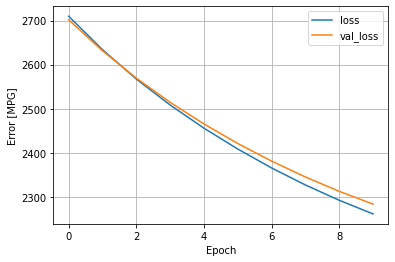

In [74]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)


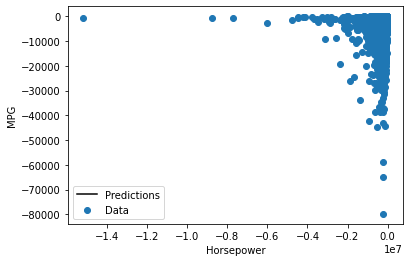

In [76]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

def plot_horsepower(x, y):
  plt.scatter(train_features['amount_y'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

plot_horsepower(x,y)


In [77]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])


In [78]:
linear_model.predict(train_features[:10])


array([[-1.647],
       [-0.052],
       [ 0.454],
       [-0.396],
       [ 0.5  ],
       [-2.575],
       [ 0.701],
       [ 0.017],
       [ 0.797],
       [-2.701]], dtype=float32)

In [79]:
linear_model.layers[1].kernel

<tf.Variable 'dense_2/kernel:0' shape=(81, 1) dtype=float32, numpy=
array([[ 0.018],
       [ 0.2  ],
       [-0.118],
       [-0.053],
       [ 0.012],
       [ 0.263],
       [ 0.17 ],
       [ 0.121],
       [-0.211],
       [-0.086],
       [-0.189],
       [-0.142],
       [ 0.168],
       [ 0.206],
       [ 0.203],
       [ 0.111],
       [-0.034],
       [ 0.101],
       [ 0.14 ],
       [ 0.048],
       [-0.151],
       [ 0.105],
       [ 0.15 ],
       [ 0.222],
       [ 0.122],
       [-0.099],
       [ 0.181],
       [-0.031],
       [-0.264],
       [ 0.083],
       [ 0.123],
       [ 0.111],
       [ 0.102],
       [ 0.074],
       [ 0.028],
       [-0.198],
       [-0.173],
       [-0.171],
       [ 0.208],
       [ 0.016],
       [ 0.257],
       [-0.242],
       [-0.021],
       [ 0.008],
       [ 0.158],
       [ 0.157],
       [-0.112],
       [ 0.067],
       [ 0.023],
       [ 0.006],
       [-0.044],
       [-0.009],
       [ 0.146],
       [ 0.111],
       [ 0.269

In [82]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')



In [86]:

%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=30,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/30
833/833 [==============================] - 1s 1ms/step - loss: 1821.4550 - val_loss: 1864.7516
Epoch 2/30
833/833 [==============================] - 1s 1ms/step - loss: 1821.4642 - val_loss: 1864.6749
Epoch 3/30
833/833 [==============================] - 1s 1ms/step - loss: 1821.4319 - val_loss: 1864.6156
Epoch 4/30
833/833 [==============================] - 1s 1ms/step - loss: 1821.4460 - val_loss: 1864.5985
Epoch 5/30
833/833 [==============================] - 1s 1ms/step - loss: 1821.4441 - val_loss: 1864.5874
Epoch 6/30
833/833 [==============================] - 1s 1ms/step - loss: 1821.4253 - val_loss: 1864.5963
Epoch 7/30
833/833 [==============================] - 1s 1ms/step - loss: 1821.4344 - val_loss: 1864.5946
Epoch 8/30
833/833 [==============================] - 1s 1ms/step - loss: 1821.4346 - val_loss: 1864.6404
Epoch 9/30
833/833 [==============================] - 1s 1ms/step - loss: 1821.4358 - val_loss: 1864.7253
Epoch 10/30
833/833 [=========================

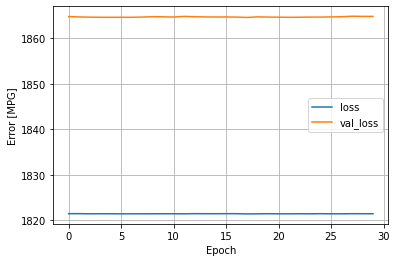

In [87]:
plot_loss(history)

In [98]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['amount_y'],
    test_labels, verbose=0)


In [143]:
normalizer = preprocessing.Normalization()


normalizer.adapt(np.array(train_features))

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_6 (Normalizati (None, 81)                163       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                5248      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 9,636
Trainable params: 9,473
Non-trainable params: 163
_________________________________________________________________


In [88]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [89]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)


In [90]:
dnn_horsepower_model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [92]:
%%time
history = dnn_horsepower_model.fit(
    train_features['amount_y'], train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)


Epoch 1/100
833/833 [==============================] - 1s 1ms/step - loss: 2369.9524 - val_loss: 2137.9910
Epoch 2/100
833/833 [==============================] - 1s 1ms/step - loss: 2085.6980 - val_loss: 2132.3999
Epoch 3/100
833/833 [==============================] - 1s 1ms/step - loss: 2082.2898 - val_loss: 2130.6909
Epoch 4/100
833/833 [==============================] - 1s 1ms/step - loss: 2081.1677 - val_loss: 2129.8784
Epoch 5/100
833/833 [==============================] - 1s 1ms/step - loss: 2080.4468 - val_loss: 2128.5210
Epoch 6/100
833/833 [==============================] - 1s 1ms/step - loss: 2079.6504 - val_loss: 2128.1970
Epoch 7/100
833/833 [==============================] - 1s 1ms/step - loss: 2079.2876 - val_loss: 2127.0239
Epoch 8/100
833/833 [==============================] - 1s 1ms/step - loss: 2078.8176 - val_loss: 2126.3894
Epoch 9/100
833/833 [==============================] - 1s 1ms/step - loss: 2077.9839 - val_loss: 2125.5620
Epoch 10/100
833/833 [===============

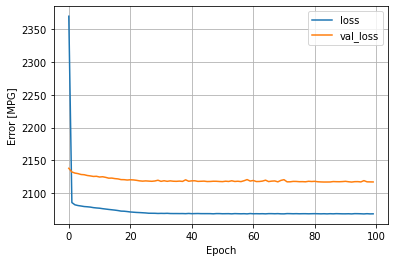

In [93]:
plot_loss(history)


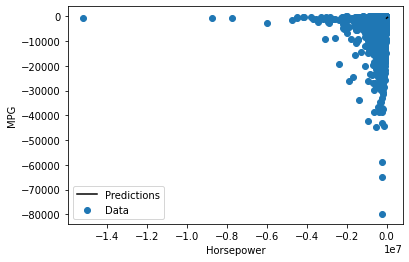

In [96]:
x = tf.linspace(0.0, 50000, 50000)
y = dnn_horsepower_model.predict(x)

plot_horsepower(x, y)


In [99]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['amount_y'], test_labels,
    verbose=0)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 81)                163       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                5248      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 9,636
Trainable params: 9,473
Non-trainable params: 163
_________________________________________________________________


In [102]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)


Epoch 1/100
833/833 [==============================] - 1s 1ms/step - loss: 1809.4878 - val_loss: 1853.8969
Epoch 2/100
833/833 [==============================] - 1s 1ms/step - loss: 1808.5790 - val_loss: 1850.3824
Epoch 3/100
833/833 [==============================] - 1s 1ms/step - loss: 1806.9427 - val_loss: 1848.9653
Epoch 4/100
833/833 [==============================] - 1s 1ms/step - loss: 1805.7120 - val_loss: 1847.7303
Epoch 5/100
833/833 [==============================] - 1s 1ms/step - loss: 1804.3109 - val_loss: 1846.4878
Epoch 6/100
833/833 [==============================] - 1s 1ms/step - loss: 1803.2025 - val_loss: 1845.9323
Epoch 7/100
833/833 [==============================] - 1s 1ms/step - loss: 1801.8116 - val_loss: 1844.6602
Epoch 8/100
833/833 [==============================] - 1s 1ms/step - loss: 1799.9473 - val_loss: 1842.0553
Epoch 9/100
833/833 [==============================] - 1s 1ms/step - loss: 1798.4796 - val_loss: 1841.3618
Epoch 10/100
833/833 [===============

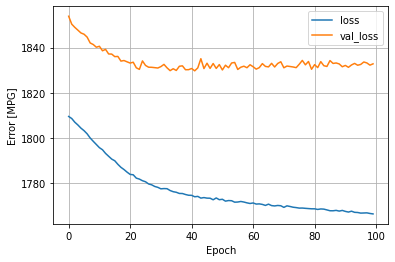

In [103]:
plot_loss(history)

In [104]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)


In [121]:
get = dnn_model.evaluate(train_features, train_labels, verbose=0)

In [123]:
test_predictions

array([-1009.934, -4108.929, -4500.934, ..., -1211.465, -2265.092,
       -1862.769], dtype=float32)

In [125]:
train_predictions = dnn_model.predict(train_features).flatten()


In [130]:
mle = statistics.mean(abs(train_labels-train_predictions))

In [131]:
mle

1775.2100879447087

In [132]:
mle2 = statistics.mean(abs(test_labels-test_predictions))

In [133]:
mle2

1850.7098438266148

In [105]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,2128.336182
dnn_horsepower_model,2132.708496
dnn_model,1850.709839


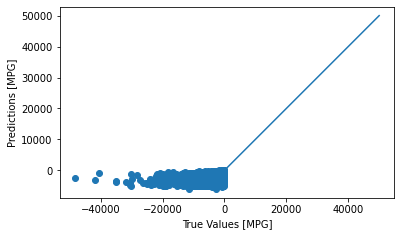

In [108]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
_ = plt.plot(lims, lims)


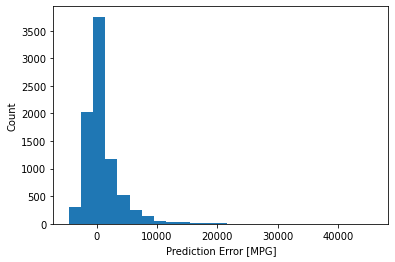

In [109]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')


In [154]:
model_type = "deep_neural_network"
print(model_type)
for cat in list(client_table_tot.merchant_category.unique()):


    category_df = client_table_tot_keras[client_table_tot["merchant_category"] == cat]
    X = category_df.drop(["amount_x"], axis = 1)
    y = category_df["amount_x"]
    
    # Note the difference in argument order
    normalizer = preprocessing.Normalization()


    normalizer.adapt(np.array(X))

    dnn_model = build_and_compile_model(normalizer)
    history = dnn_model.fit(
    X, y,
    validation_split=0.2,
    verbose=0, epochs=20)
    
    dnn_model.save(f'../content/drive/My Drive/CS_HACKATHON/dnn/{model_type}_{cat}')

    predictions = dnn_model.predict(X) # make the predictions by the model
    # Print out the statistics
    print(cat, sklearn.metrics.mean_absolute_error(y, predictions))



deep_neural_network
INFO:tensorflow:Assets written to: ../content/drive/My Drive/CS_HACKATHON/dnn/deep_neural_network_Atm/assets
Atm 27609.898492628203
INFO:tensorflow:Assets written to: ../content/drive/My Drive/CS_HACKATHON/dnn/deep_neural_network_Beauty/assets
Beauty 2139.3647921896486
INFO:tensorflow:Assets written to: ../content/drive/My Drive/CS_HACKATHON/dnn/deep_neural_network_Car/assets
Car 8254.364772600424
INFO:tensorflow:Assets written to: ../content/drive/My Drive/CS_HACKATHON/dnn/deep_neural_network_Children/assets
Children 1311.3159602402827
INFO:tensorflow:Assets written to: ../content/drive/My Drive/CS_HACKATHON/dnn/deep_neural_network_Consumer Goods/assets
Consumer Goods 2562.046200214084
INFO:tensorflow:Assets written to: ../content/drive/My Drive/CS_HACKATHON/dnn/deep_neural_network_Digital Services/assets
Digital Services 4924.39707455627
INFO:tensorflow:Assets written to: ../content/drive/My Drive/CS_HACKATHON/dnn/deep_neural_network_Drugstore/assets
Drugstore 183

In [153]:

dnn_model.save(f'../content/drive/My Drive/CS_HACKATHON/dnn/{model_type}_{cat}')

INFO:tensorflow:Assets written to: ../content/drive/My Drive/CS_HACKATHON/dnn/deep_neural_network_Atm/assets
